In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10

In [3]:
# Import Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print("Classes:", class_names)


Found 2152 files belonging to 3 classes.
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [8]:
# Split Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [9]:
# Preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
@register_keras_serializable() 
class CustomConv2D(tf.keras.layers.Layer):
    """Manually implemented Convolution operation."""
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
        super(CustomConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding

    def build(self, input_shape):
        self.conv_filter = self.add_weight(
            name="conv_filter", 
            shape=(self.kernel_size, self.kernel_size, input_shape[-1], self.filters),
            initializer="random_normal"
        )
        self.bias = self.add_weight(
            name="bias", 
            shape=(self.filters,),
            initializer="zeros"
        )

    def call(self, input_tensor):
        conv_output = tf.nn.conv2d(
            input_tensor, 
            self.conv_filter, 
            strides=[1, *self.strides, 1], 
            padding=self.padding.upper()
        )
        return tf.nn.relu(conv_output + self.bias)

    def get_config(self):
        config = super(CustomConv2D, self).get_config()
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "strides": self.strides,
            "padding": self.padding,
        })
        return config

In [25]:
# Mixed Model
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable()
class MixedCNN(tf.keras.Model):
    def __init__(self, num_classes, **kwargs):
        super(MixedCNN, self).__init__(**kwargs)
        
        # Layers
        self.resize_and_rescale = resize_and_rescale
        self.data_augmentation = data_augmentation
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')
        self.custom_conv = CustomConv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same')
        
    def call(self, inputs):
        # Resize & Normalize
        x = self.resize_and_rescale(inputs)
        x = self.data_augmentation(x)

        # Manual Convolution Layer
        x = self.custom_conv(x)
        
        # Max Pooling
        x = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='SAME')
        
        # Library-Based Layers
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)
        
    def get_config(self):
        config = super(MixedCNN, self).get_config()
        config.update({
            "num_classes": self.dense2.units,
        })
        return config
        

In [26]:
# Initialize Model
# Initialize Model
model = MixedCNN(num_classes=len(class_names))
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])


In [27]:
# Training
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.5326 - loss: 4.9551 - val_accuracy: 0.8125 - val_loss: 0.3966
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 345s 4s/step - accuracy: 0.8426 - loss: 0.3887 - val_accuracy: 0.8802 - val_loss: 0.2790
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8603 - loss: 0.3107 - val_accuracy: 0.8542 - val_loss: 0.3345
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.8693 - loss: 0.3290 - val_accuracy: 0.9323 - val_loss: 0.1747
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.9249 - loss: 0.2091 - val_accuracy: 0.9531 - val_loss: 0.1705
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.9284 - loss: 0.1875 - val_accuracy: 0.9635 - val_loss: 0.1362
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.9290 - loss: 0.1832 - val_accuracy: 0.9531 - val_loss: 0.1641
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.9297 - loss: 0.1871 - val_accuracy: 0.9688 - v

In [28]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 977ms/step - accuracy: 0.9747 - loss: 0.1502
Test Accuracy: 0.96


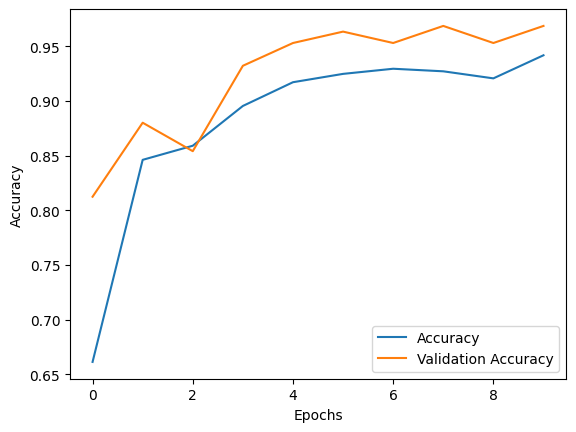

In [29]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
# Now save the model
model.save('model.keras')
print("Model saved successfully!")

Model saved successfully!


In [26]:
# # Create a test input tensor
# test_input = tf.random.normal((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# # Instantiate the custom layer
# custom_conv_layer = CustomConv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same')

# # Build the layer to initialize weights
# custom_conv_layer.build(test_input.shape)

# # Pass the test input through the custom layer
# output = custom_conv_layer(test_input)

# # Print the output shape
# print("Output shape of CustomConv2D:", output.shape)

# # Print the number of parameters in the custom layer
# num_params = custom_conv_layer.count_params()
# print("Number of parameters in CustomConv2D:", num_params)

Output shape of CustomConv2D: (32, 256, 256, 32)
Number of parameters in CustomConv2D: 896


In [23]:
# from tensorflow.keras.saving import register_keras_serializable

# print(get_custom_objects())


{'Custom>CustomConv2D': <class '__main__.CustomConv2D'>, 'Custom>MixedCNN': <class '__main__.MixedCNN'>, 'CustomConv2D': <class '__main__.CustomConv2D'>, 'MixedCNN': <class '__main__.MixedCNN'>}
